In [9]:
import numpy as np
import matplotlib.pylab as plt
import sys
from trajectory import trajectory
np.set_printoptions(precision=2)

# Třída pro Kalmanův filtr

Můžete vykopírovat a importovat ze souboru pro snazší ladění.

In [2]:
class KF():
    def __init__(self, A, B, H, R, Q):
        self.A = A
        self.B = B
        self.H = H
        self.R = R
        self.Q = Q
        self.P = np.eye(self.Q.shape[0]) * 10000
        self.x = np.ones(self.Q.shape[0])
        self.log_x = []
    
    def predict(self, u=None):
        xminus = self.A.dot(self.x)
        Pminus = self.A.dot(self.P).dot(self.A.T) + self.Q
        self.x = xminus
        self.P = Pminus
    
    def correct(self, yt):
        HPHT = self.H.dot(self.P).dot(self.H.T)
        zavorka_inv = np.linalg.inv(HPHT + self.R)
        K = self.P.dot(self.H.T).dot(zavorka_inv)
        innovation = yt - self.H.dot(self.x)
        xplus = self.x + K.dot(innovation)
        zavorka = np.eye(K.shape[0]) - K.dot(self.H)
        KRKT = K.dot(self.R).dot(K.T)
        Pplus = zavorka.dot(self.P).dot(zavorka.T) + KRKT
        self.x = xplus
        self.P = Pplus
    
    def log(self):
        self.log_x.append(self.x)

# Cvičení: Sledování objektu ve 2D

Cílem tohoto cvičení je filtrace polohy objektu pohybujícího se na ploše, tj. ve 2D. Cílem je odhadovat stavový vektor sestávající se z polohy v osách $x_1$ a $x_2$ a rychlostech v obou těchto osách.

$$
x_t =
\begin{bmatrix}
x_{1,t} \\ 
x_{2,t} \\ 
v_{x_1,t} \\ 
v_{x_2,t}
\end{bmatrix}
$$

Víme, že pro polohu v první ose platí

$$
x_{1,t} = x_{1,t-1} + v_{x_1,t} dt + w_{x_1,t},
$$

a že analogicky platí totéž i pro polohu v ose druhé. Abychom se nemuseli zaobírat zrychlením, budeme uvažovat, že rychlost je stejná a její změny jsou způsobeny jen šumem,

$$
v_{x_1,t} = v_{x_1, t-1} + w_{vx_1, t}.
$$

Analogicky pro druhou složku rychlosti. K dispozici jsou jen měření polohy v obou osách a to v časovém kroku 1s.

Potřebujeme tedy sestavit stavový model

$$
\begin{align}
x_t &= A_t x_{t-1} + B_t u_t + w_t, &w_t \sim (0, Q_t),\\
y_t &= H_t x_t + \varepsilon_t, &\varepsilon_t \sim (0, R_t).
\end{align}
$$

**Úkol 1: Sestavte stavový model a určete matice**

Kovarianční matice nám musí někdo dodat, níže jsou uvedeny.

\begin{align*}
    A &=
    \begin{bmatrix}
       1 & 0 & dt & 0 \\
       0 & 1 & 0 & dt \\
       0 & 0 & 1 &  0 \\
       0 & 0 & 0 &  1 
    \end{bmatrix},
    \quad
    &Q &= q^2 \cdot
    \begin{bmatrix}
        \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2}  & 0  \\
        0                 & \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2} \\
        \frac{dt^{2}}{2}  & 0                 & dt                & 0 \\
        0                 & \frac{dt^{2}}{2}  & 0                 & dt
    \end{bmatrix}
    \notag \\
    H &=
    \begin{bmatrix}
        1 & 0 &0 & 0 \\
        0 & 1 &0 & 0
    \end{bmatrix}
    \quad
    &R &=
    r^{2}\cdot
    \begin{bmatrix}
        1 & 0 \\
        0 & 1
    \end{bmatrix}
\end{align*}
kde $dt = 1$, $q = \sqrt{.5}$, $r=3$.

**Úkol 2: dodefinujte proměnné**

In [3]:
q = np.sqrt(.5)
dt = 1
r = 3.
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1,  0],
              [0, 0, 0,  1]])
Q = q**2 * np.array([[dt**3/3, 0      , dt**2/2, 0      ],
                     [0,       dt**3/3, 0,       dt**2/2],
                     [dt**2/2, 0,       dt,      0      ],
                     [0,       dt**2/2, 0,       dt     ]])
H = np.array([[1., 0, 0, 0],
              [0., 1, 0, 0]])
R = r**2 * np.eye(2)

**Úkol 3: doplňte za `code` libovolné číslo. V objektu `traj` budete mít trajektorii o `ndat` řádcích, v každém je poloha v obou osách. Vykreslete ji křížky a diskutujte o jejích vlastnostech. Zkoušejte měnit `q` a `r` a pozorujte, co to s daty dělá.**

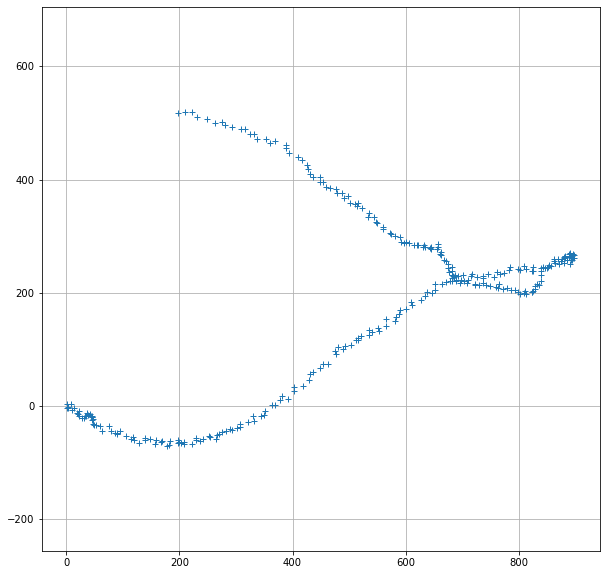

In [10]:
code = 1003
traj = trajectory(code, ndat=300, q=q, r=r)
plt.figure(figsize=(10, 10))
plt.plot(traj.Y[0,:], traj.Y[1,:], '+')
plt.axis('equal')
plt.show()

Kalmanův filtr je napsán jako třída KF. Tu si jednoduše pustíme, provede výpočty za vás. Předávají se jí jednotlivá měření polohy, tj. řádky v `traj.Y.T`

In [35]:
kf = KF(A=A, B=None, H=H, R=R, Q=Q)
for t, yt in enumerate(traj.Y.T):
    kf.predict()
    #if t < 100 or t > 150:
    kf.correct(yt)
    kf.log()

log_x = np.array(kf.log_x).T      # Zde najdeme odhad

**Úkol 4: `log_x` má 4 řádky, v každém sloupci je jeden odhad stavu $x_{t}$. Vykreslíme stejně jako výše naměřenou polohu a její filtrovaný odhad. Pozorujte, co se s daty děje, pokud měníte `q` a `r` výše.**

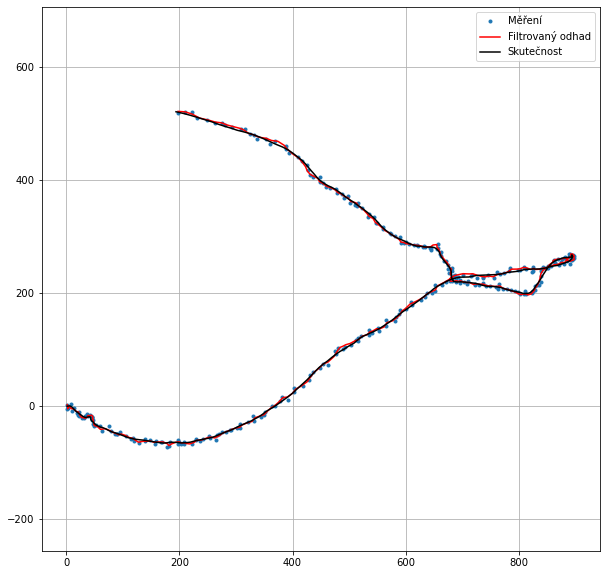

In [36]:
plt.figure(figsize=(10,10))
plt.plot(traj.Y[0,:], traj.Y[1,:], '.', label='Měření')
plt.plot(log_x[0,:], log_x[1,:], '-', color='red', label='Filtrovaný odhad')
plt.plot(traj.X[0,:], traj.X[1,:], 'k', label='Skutečnost')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

Protože v grafu výše je vykreslena celá 2D plocha, podívejme se i na jednotlivé složky (směry).

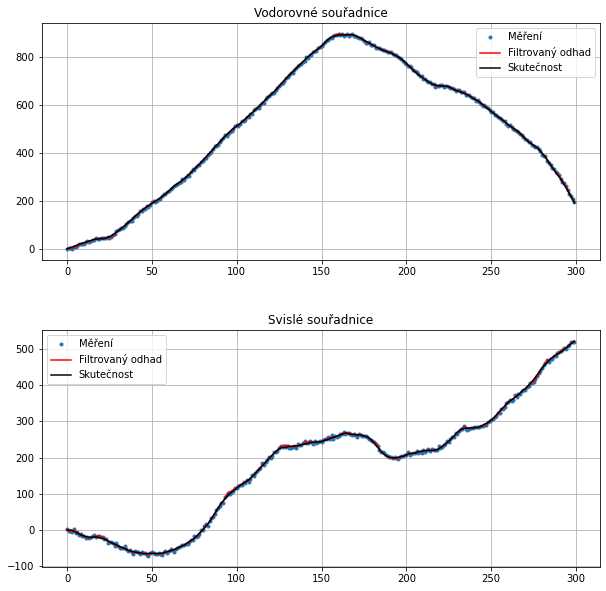

In [37]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Vodorovné souřadnice')
plt.plot(traj.Y[0,:], '.', label='Měření')
plt.plot(log_x[0,:], '-', color='red', label='Filtrovaný odhad')
plt.plot(traj.X[0,:], 'k', label='Skutečnost')
plt.grid(True)
plt.legend()
plt.subplot(2,1,2)
plt.title('Svislé souřadnice')
plt.plot(traj.Y[1,:], '.', label='Měření')
plt.plot(log_x[1,:], '-', color='red', label='Filtrovaný odhad')
plt.plot(traj.X[1,:], 'k', label='Skutečnost')
plt.grid(True)
plt.legend()
plt.show()

**Úkol 5: V odhadech najdete i odhady rychlosti. Vykreslíme je jako 2 subploty vedle sebe a pozorujme opět, jak se mění kvalita odhadu při změnách `q` a `r`.**

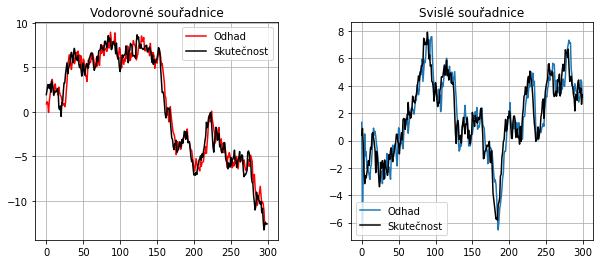

In [38]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.title('Vodorovné souřadnice')
plt.plot(log_x[2,:], 'r', label='Odhad')
plt.plot(traj.X[2,:], 'k', label='Skutečnost')
plt.legend()
plt.subplot(1,2,2)
plt.title('Svislé souřadnice')
plt.plot(log_x[3,:], label='Odhad')
plt.plot(traj.X[3,:], 'k', label='Skutečnost')
plt.legend()
plt.show()

**Zbyde-li čas, zkuste:**

- vykreslit rezidua odhadu
- vynechat pár měření a postupovat jen s predikcí, nikoliv korekcí
- použít nesprávné kovariance šumu
- odstartovat ze špatného iniciálního odhadu stavu.